In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_ROOT = Path("../data") / "jigsaw"

# Vocabulary

Vocabulary overlap between train and test sets

In [3]:
train, test = [pd.read_csv(DATA_ROOT / fname) for fname in ["train.csv", "test_proced.csv"]]

In [5]:
import spacy
nlp = spacy.load('en_core_web_sm')
def tok(s): return [tok.text for tok in nlp.tokenizer(s)]

In [6]:
train_parsed_sentences = [
    tok(row["comment_text"]) for i, row in train.iterrows()
]

In [7]:
test_parsed_sentences = [
    tok(row["comment_text"]) for i, row in test.iterrows()
]

Write as fasttext files

In [8]:
with open(DATA_ROOT / "train.ft_txt", "wt") as f:
    f.write("\n".join([" ".join(s) for s in train_parsed_sentences]))

In [9]:
with open(DATA_ROOT / "test.ft_txt", "wt") as f:
    f.write("\n".join([" ".join(s) for s in test_parsed_sentences]))

In [25]:
from collections import Counter
train_freqs = Counter()
test_freqs = Counter()
for s in train_parsed_sentences: train_freqs.update([w.lower() for w in s])
for s in test_parsed_sentences: test_freqs.update([w.lower() for w in s])

In [26]:
train_vocab = set(train_freqs.keys())
test_vocab = set(test_freqs.keys())

Basic analysis

In [27]:
len(train_vocab), len(train_vocab) / len(train_parsed_sentences)

(221572, 1.388548044444166)

In [28]:
len(test_vocab), len(test_vocab) / len(test_parsed_sentences)

(162580, 2.5411860326987403)

Number of terms unique to test set (60% of the terms are unique!!)

In [53]:
len(test_vocab - train_vocab) 

97067

In [29]:
len(test_vocab - train_vocab) / len(test_vocab)

0.5970414565137163

Distribution of frequencies

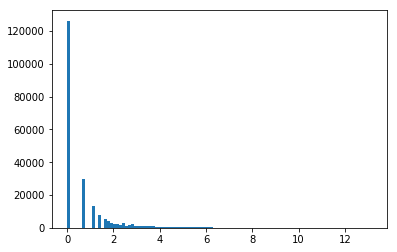

In [30]:
plt.hist(np.log([x for x in train_freqs.values()]), bins=100);

### Contrast with SST

In [16]:
sst_train, sst_test = [pd.read_csv(Path("../data") / "sst-2" / fname, sep="\t") for fname in ["train.tsv", "test.tsv"]]

In [17]:
sst_train_parsed_sentences = [
    tok(row["sentence"]) for i, row in sst_train.iterrows()
]
sst_test_parsed_sentences = [
    tok(row["sentence"]) for i, row in sst_test.iterrows()
]

In [18]:
from collections import Counter
sst_train_freqs = Counter()
sst_test_freqs = Counter()
for s in sst_train_parsed_sentences: sst_train_freqs.update(s)
for s in sst_test_parsed_sentences: sst_test_freqs.update(s)

In [19]:
sst_train_vocab = set(sst_train_freqs.keys())
sst_test_vocab = set(sst_test_freqs.keys())

In [20]:
len(sst_train_vocab), len(sst_train_vocab) / len(sst_train_parsed_sentences)

(13915, 0.20661034313798274)

In [21]:
len(sst_test_vocab), len(sst_test_vocab) / len(sst_test_parsed_sentences)

(6889, 3.7830862163646346)

In [22]:
len(sst_test_vocab - sst_train_vocab) / len(sst_test_vocab)

0.24401219335172014

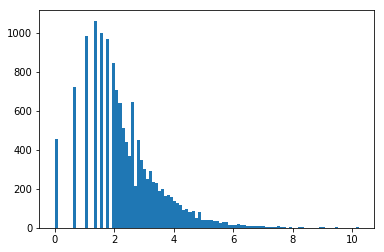

In [23]:
plt.hist(np.log([x for x in sst_train_freqs.values()]), bins=100);

# OOV words

In [31]:
test_vocab - train_vocab

{'seras',
 'laqaadaa',
 'splitting#procedure',
 'unionville',
 'poam',
 'طرفی',
 'nahda',
 'berzcasca',
 'jdd',
 '~matt',
 'years=',
 'progran',
 'pakistanspace.tripod.com/khurram/tjr.htm',
 '||italy',
 'hous',
 'bombe',
 'painman',
 'yorke',
 '-by',
 'beberapa',
 'عينيكى',
 'أصغر',
 '↑ɻ⅞θʉɭђɥл₮₴ṝ',
 'fss',
 'ফাউন্ডেশন',
 'microkorg',
 'shankargarhi',
 'করছে',
 'تم',
 'taraak',
 'tgfd43249328043092849238904398024890324',
 'રહેતા',
 'purpled',
 'liquidaiton',
 'octubre',
 'intrepido',
 'بالأزرار',
 'pageantry',
 'pedosexuality',
 'ابتدائی',
 'chanman121',
 'rimski',
 'როგორმე',
 'valluvar',
 'prüfung',
 'mallika',
 'tascosa',
 '7f',
 'annonces',
 'phatuam',
 'corporis',
 'communication)insisted',
 'livian',
 'bedder',
 'contentcurrent',
 'chibistan',
 '3.24',
 'dewdney',
 'desinformation',
 'χρόνων.',
 'wunker',
 'ሽረ',
 'duvide',
 'ternary',
 'motorfreaks',
 'lomax',
 'poo==',
 'sysutils',
 'dow.',
 'متنفريم',
 'notice=',
 'tmunot',
 'hoffe',
 'ஒருங்கிணைப்பை',
 '1)(d',
 'وزبزبة',
 'ngay

# Some simple denoising

### Repitition

In [33]:
from dataclasses import dataclass

In [44]:
@dataclass
class RepeatTracker:
    prev_prev_char: str = None
    prev_char: str = None
    
    def is_repeat(self, c: str) -> bool:
        rep = c == self.prev_char and self.prev_char == self.prev_prev_char
        # track state
        self.prev_prev_char = self.prev_char
        self.prev_char = c
        return rep

In [45]:
def remove_repeats(s: str):
    """Deduplicate characters that appear more than 2 times in a row"""
    tracker = RepeatTracker()
    return "".join(
        [c for c in s if not tracker.is_repeat(c)]
    )

In [46]:
remove_repeats("hello this is a pen")

'hello this is a pen'

In [47]:
remove_repeats("heeeeeelloo this is a pen")

'heelloo this is a pen'

In [48]:
remove_repeats("heeeeeellllol this is a pen")

'heellol this is a pen'

In [51]:
denoised_test_vocab = set([remove_repeats(w) for w in test_vocab])
denoised_train_vocab = set([remove_repeats(w) for w in train_vocab])

We get a slight decrease...

In [52]:
len(denoised_test_vocab - denoised_train_vocab)

96008

### URLs

In [60]:
import re
url_regexp = re.compile("https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+")

In [63]:
url_regexp.match("http://www.foo.com.hoge.foo/aaa?dfja")

<_sre.SRE_Match object; span=(0, 27), match='http://www.foo.com.hoge.foo'>

In [64]:
url_regexp.match("http:///www.foo.com.hoge.foo/aaa?dfja")

In [65]:
denoised_test_vocab = set([w for w in denoised_test_vocab if url_regexp.match(w) is None])
denoised_train_vocab = set([w for w in denoised_train_vocab if url_regexp.match(w) is None])

Another decrease!

In [66]:
len(denoised_test_vocab - denoised_train_vocab)

93522

### Removing numbers

In [70]:
num_regexp = re.compile("^[0-9]+$")

In [71]:
num_regexp.match("1989")

<_sre.SRE_Match object; span=(0, 4), match='1989'>

In [73]:
num_regexp.match("198a")

In [74]:
num_regexp.match("a198")

In [75]:
denoised_test_vocab = set([w for w in denoised_test_vocab if num_regexp.match(w) is None])
denoised_train_vocab = set([w for w in denoised_train_vocab if num_regexp.match(w) is None])

In [76]:
len(denoised_test_vocab - denoised_train_vocab)

92415

# Can we spell correct using embeddings?

In [94]:
import fastText

In [95]:
ft_model = fastText.load_model(str(DATA_ROOT / "jigsaw_model.bin"))

In [96]:
word_vectors = {w: ft_model.get_word_vector(w) for w in ft_model.get_words()}

In [116]:
def cosine_similarity(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

from heapq import heappush, heappop
def nearest_neighbors(word, n=10, max_freq=None):
    x = ft_model.get_word_vector(word)
    heap = []
    for w, v in word_vectors.items():
        if max_freq is not None and train_freqs[w] > max_freq: continue
        sim = cosine_similarity(x, v)
        if len(heap) < n:
            heappush(heap, (sim, w))
        else:
            if heap[0] < (sim, w):
                heappop(heap)
                heappush(heap, (sim, w))
    return sorted(heap, reverse=True)

In [117]:
nearest_neighbors("hello")

[(1.0000001, 'hello'),
 (0.54531354, '|hello'),
 (0.50405526, 'hellor'),
 (0.46177784,
  'http://www.urbandictionary.com/define.php?term=BatteryIncluded%20and%20Apokryltaros&defid;=7940701'),
 (0.45322883, 'hella'),
 (0.41515225, 'Hello'),
 (0.41504452, 'Othello'),
 (0.40933764, 'bello'),
 (0.40864664, 'i'),
 (0.39541024, 'Welcome!Hello')]

In [121]:
nearest_neighbors("fuck", n=30, max_freq=None)

[(1.0, 'fuck'),
 (0.71109784, 'fucky'),
 (0.7018619, 'yourselfgo'),
 (0.6390364, 'niggas'),
 (0.63388884, 'fucka'),
 (0.6241736, '@/\\/+u'),
 (0.6170343, 'misterwiki'),
 (0.6115249, 'd3$1r'),
 (0.6042792, 'fuc*ing'),
 (0.60393906, 'bitches.fuck'),
 (0.5953338, '62.158.73.165'),
 (0.5914404, 'fucksex'),
 (0.5914125, 'ashol'),
 (0.588362, 'malusia'),
 (0.57525295, 'fuc'),
 (0.5730932, 'Fucky'),
 (0.56682396, 'yoy'),
 (0.56012464, 'ass!Fuck'),
 (0.5553477, 'fuckstick'),
 (0.53864944, 'ashit'),
 (0.53292435, 'fucking'),
 (0.525525, 'aot'),
 (0.5254815, 'shgit'),
 (0.51831734, 'whore!eat'),
 (0.51797044, 'Go'),
 (0.51698583, 'shiot'),
 (0.5144625, 'shitFuck'),
 (0.5136622, 'shioty'),
 (0.5058249, 'gg'),
 (0.50398856, 'FUCKEN')]

In [120]:
nearest_neighbors("fuck", n=30, max_freq=2)

[(0.5730932, 'Fucky'),
 (0.56012464, 'ass!Fuck'),
 (0.51797044, 'Go'),
 (0.5144625, 'shitFuck'),
 (0.50398856, 'FUCKEN'),
 (0.49106547, 'dickBig'),
 (0.49081677, 'buSh'),
 (0.4896593, 'bitchMother'),
 (0.47714946, 'suckS'),
 (0.47627318, 'ancestryFuck'),
 (0.4757869, 'faggot!!!!Jéské'),
 (0.47560382, 'Bongwarriorcongratualtions'),
 (0.47558245, 'faggotMONGO'),
 (0.4751744, 'Notrhbysouthbanof'),
 (0.47097516, 'Fuck'),
 (0.46741462, 'retardMONGO'),
 (0.46655396, 'bUsh'),
 (0.46452147, 'tEh'),
 (0.4614357, 'OFFFUCK'),
 (0.46137694, 'FUCKK'),
 (0.4573362, 'HAND.faggotMONGO'),
 (0.45694146, 'it.""""Bitch'),
 (0.4559379, 'FGGT'),
 (0.45290092, 'Fan-1967'),
 (0.45119444, 'FoReVeR'),
 (0.45069972, 'WACKO'),
 (0.4504874, 'aRe'),
 (0.45030543, 'FAGGOT'),
 (0.44894904, 'BLEACHANHERO'),
 (0.44891208, 'F@GGOT')]

In [110]:
nearest_neighbors("nigga", n=30)

[(1.0, 'nigga'),
 (0.76812077, 'niggaz'),
 (0.70144916, 'niggas'),
 (0.6544976, 'Nigga'),
 (0.5773974, 'niggardly'),
 (0.48689127, 'ganna'),
 (0.48483732, 'bitch'),
 (0.48362437, 'nigger'),
 (0.48207304, 'mutha'),
 (0.48016408, 'niggers'),
 (0.47714293, 'ashit'),
 (0.4693819, 'fcuk'),
 (0.46933064, 'fckin'),
 (0.46855983, 'myles'),
 (0.46609938, '@/\\/+u'),
 (0.45738328, 'fcken'),
 (0.45651972, 'bitches.fuck'),
 (0.4545034, 'shgit'),
 (0.45431292, 'fucka'),
 (0.45381734, 'doosh'),
 (0.44882894, 'yoy'),
 (0.44464716, 'ass'),
 (0.4440089, 'aot'),
 (0.44366586, 'myo'),
 (0.4411442, 'yourselfgo'),
 (0.44085807, 'd3$1r'),
 (0.4402051, 'bitchMother'),
 (0.43842676, 'shioty'),
 (0.43722463, 'fukin'),
 (0.43699828, 'RAWR')]

In [111]:
nearest_neighbors("shit", n=30)

[(1.0, 'shit'),
 (0.6572481, 'ashit'),
 (0.6148057, 'shgit'),
 (0.6077305, 'shioty'),
 (0.60361385, 'shiot'),
 (0.5875714, 'shoit'),
 (0.5862358, 'hsoit'),
 (0.5835266, 'aot'),
 (0.56271935, 'ahot'),
 (0.5529605, 'shti'),
 (0.5382499, 'piece'),
 (0.5198875, 'shitFuck'),
 (0.51926255, 'sht'),
 (0.51698554, 'Notrhbysouthbanof'),
 (0.51440406, 'fucking'),
 (0.5136827, 'ass'),
 (0.51244426, 'sh!t'),
 (0.5043142, 'shits'),
 (0.5019324, 'sot'),
 (0.4837982, 'shitbag'),
 (0.48196018, 'kwa'),
 (0.47800198, 'bitch'),
 (0.4749033, 'ahole'),
 (0.47206512, 'myles'),
 (0.4709434, 'shyt'),
 (0.4675216, 'motherfucking'),
 (0.46299925, 'butthole'),
 (0.45588112, 'faggot'),
 (0.45324886, 'Motherfucking'),
 (0.449606, 'fatass')]

In [122]:
nearest_neighbors("shit", n=30, max_freq=3)

[(0.5198875, 'shitFuck'),
 (0.51698554, 'Notrhbysouthbanof'),
 (0.45324886, 'Motherfucking'),
 (0.44247538, 'Bradbury'),
 (0.44019768, 'bitchMother'),
 (0.43868962, 'buSh'),
 (0.42333588, 'ass!Fuck'),
 (0.41983578, 'Motherfucker'),
 (0.41927108, 'Fuck'),
 (0.416493, 'Shove'),
 (0.41473627, 'GARBAGE'),
 (0.40359667, 'bUsh'),
 (0.39910036, 'dickBig'),
 (0.39865327, 'Faggot'),
 (0.39431655, 'suckS'),
 (0.3930912, 'Alstair'),
 (0.39257228, 'faggot!!!!Jéské'),
 (0.38904762, 'Bongwarriorcongratualtions'),
 (0.38744184, 'Edgar181'),
 (0.38529128, 'NHRHS2010/Hitler'),
 (0.38413492, 'bitchMattythewhite'),
 (0.38319618, 'FGGT'),
 (0.3823751, 'busH'),
 (0.38177776, 'ancestryFuck'),
 (0.38006446, 'FIXING'),
 (0.3799334, 'NHRHS2010'),
 (0.37604764, 'cheeseI'),
 (0.3754368, 'HEADS'),
 (0.37325594, 'Scumbag'),
 (0.37111962, 'FUCKEN')]

In [112]:
nearest_neighbors("bitch", n=30)

[(0.9999999, 'bitch'),
 (0.6124655, 'bitchMother'),
 (0.56821156, 'motherfucker'),
 (0.54925597, 'motherfuckers'),
 (0.54788405, 'Sannse'),
 (0.5391741, 'Motherfucker'),
 (0.5377474, 'fucka'),
 (0.53611076, 'bitchMattythewhite'),
 (0.53400165, 'bitches'),
 (0.5285885, 'motherfucking'),
 (0.5229482, '62.158.73.165'),
 (0.51832926, 'bitchy'),
 (0.51085055, 'ass'),
 (0.503697, 'Motherfucking'),
 (0.4967802, 'Ilchee'),
 (0.48971605, 'bitches.fuck'),
 (0.48684308, 'sonofabitch'),
 (0.485358, 'fuc*ing'),
 (0.48483732, 'nigga'),
 (0.47813663, 'sh!t'),
 (0.47800198, 'shit'),
 (0.47793558, 'Fucker'),
 (0.47456375, 'Billj'),
 (0.46835187, 'fuck'),
 (0.4657153, 'ashit'),
 (0.46396202, 'Dumbass'),
 (0.4638707, 'shgit'),
 (0.4612958, 'fucker'),
 (0.46071222, '^^^^^^'),
 (0.4594326, 'faggot!!!!Jéské')]

Kinds of noise

- Repeat chars
- Repeat word
- Remove spaces
- Append weird words (e.g. stick)
- Append offensive words
    - sex
    - bitch
    - fuck
    - ass
- Remove characters (e.g. asshol)
- Replace chars (e.g. i -> !)